In [1]:
import pickle
import random
import time
from math import ceil
from typing import List
from typing import Set
from typing import Tuple

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from evaluation import MyPredictionModel
from evaluation import evaluate_graphs
from graph import Graph
from mapping import Mapper, FamilyIdMapper, PartIdMapper
from node import Node
from part import Part
from utils import load_graphs
import os

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
graphs = load_graphs()
random.shuffle(graphs)


model_fam_exists = os.path.exists("data/karl_fam.dat")
model_part_exists = os.path.exists("data/karl_part.dat")

True


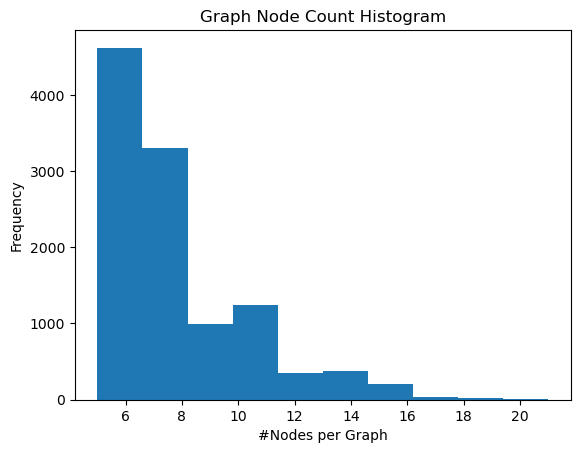

In [2]:
a = [len(g.get_nodes()) for g in graphs]
_ = plt.hist(a)  # arguments are passed to np.histogram
plt.title("Graph Node Count Histogram")
plt.xlabel("#Nodes per Graph")
plt.ylabel("Frequency")
plt.show()

Load graphs dataset, shuffle it and split it into training, validation and test set.

In [3]:
training_set_size_ratio = 0.8
validation_set_size_ratio = 0.10
test_size_ratio = 0.10

assert training_set_size_ratio + test_size_ratio + validation_set_size_ratio == 1

# Dense Family ID Mapping
All parts have a family that lies between 0 and 95 (inclusive). However, some family IDs, like 16, don't appear in the dataset. We create a dense family ID mapping and use dense family IDs to shorten our model's feature vector. For example, family ID 17 is converted to dense Family ID 16 due to the gap Family ID 16 left.

In [4]:
fam_mapper = FamilyIdMapper(graphs)


def get_ofid(self):
    """
    :return: the original family if of the node's part
    """
    return int(self.get_family_id())


def get_dfid(self):
    """
    :return: the dense family if of the node's part
    """
    return fam_mapper.to_dense(self.get_ofid())


# Add extension functions to nodes to make code easier to read
Part.get_ofid = get_ofid
Part.get_dfid = get_dfid

# Dense Part ID Mapping

We compare the predictions of the model using only the family ID against using only the part ID. Hence we setup the part ID mapping analogously.

In [5]:
part_mapper = PartIdMapper(graphs)

def get_opid(self):
    """
    :return: the original part id of the node's part
    """
    return int(self.get_part_id())


def get_dpid(self):
    """
    :return: the dense part id of the node's part
    """
    return part_mapper.to_dense(self.get_opid())


# Add extension functions to nodes to make code easier to read
Part.get_opid = get_opid
Part.get_dpid = get_dpid

# Model Hyperparameters

For initially comparing the two models we set the hyperparameters as following. We do hyperparameter optimization later as we determined the better alternative between using only family IDs or only part IDs as features

In [6]:
batch_size = 512

input_size_fam = 2 * len(fam_mapper)  # 184
hidden_size_fam = 2 * input_size_fam # 368
output_size_fam = len(fam_mapper)  # 92

input_size_part = 2 * len(part_mapper)  # 2162
hidden_size_part = 2 * input_size_part # 4324
output_size_part = len(part_mapper)  # 1081


learning_rate = 0.003
num_epochs = 50

# Our Model KantenKennerKarl

It is a simple Feedforward neural network consisting of just one hidden layer. This makes it extremely efficient. The model does not directly predict the edges for a set of parts. Instead, it predicts all the neighbors of one node of a Graph.

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 2 * hidden_size)
        self.fc2 = nn.Linear(2 * hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## Model Features

The model takes a 1D tensor that can be divided into two parts `all_nodes_tensor` (first half) and `given_node_tensor` (second half):
- `all_nodes_tensor`: one-hot encoded dense family IDs for each part that we should use to build the graph. E.g., (1,0,3,0,...,0) means that the graph consists of one part with dense family ID 0 and three parts with dense family ID 2.
- `given_node_tensor`: one-hot encoded dense family ID for which the model should predict its neighbors. E.g., (0,0,1,0,...,0) means that the model should predict the neighbors of all parts with dense family id 2.

We do the same analogously for the approach using only the part IDs

In [8]:
def create_features_family_id(parts: Set[Part], fam_mapping: FamilyIdMapper) -> List[Tensor]:
    parts_sorted = list(parts)
    parts_sorted.sort()

    num_different_family_ids = len(fam_mapping)

    all_nodes_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)

    for part in parts_sorted:
        dense_family_id = part.get_dfid()
        all_nodes_tensor[dense_family_id] += 1.0

    feature_tensors = []

    for part in parts_sorted:
        dense_family_id = part.get_dfid()
        given_node_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)
        given_node_tensor[dense_family_id] = 1
        feature_tensor = torch.cat((all_nodes_tensor, given_node_tensor), dim=-1)
        feature_tensors.append(feature_tensor)

    return feature_tensors

def create_features_part_id(parts: Set[Part], part_mapper: PartIdMapper) -> List[Tensor]:
    parts_sorted = list(parts)
    parts_sorted.sort()

    num_different_part_ids = len(part_mapper)

    all_nodes_tensor = torch.zeros(num_different_part_ids, dtype=torch.float)

    for part in parts_sorted:
        dense_part_id = part.get_dpid()
        all_nodes_tensor[dense_part_id] += 1.0

    feature_tensors = []

    for part in parts_sorted:
        dense_part_id = part.get_dpid()
        given_node_tensor = torch.zeros(num_different_part_ids, dtype=torch.float)
        given_node_tensor[dense_part_id] = 1
        feature_tensor = torch.cat((all_nodes_tensor, given_node_tensor), dim=-1)
        feature_tensors.append(feature_tensor)

    return feature_tensors

## Model Labels

The model outputs a 1D tensor that represents the neighbors of a given node. E.g., (1,0,1,0,...,0) means that the given node (only) has two neighbors: one with dense family ID 0 and one with dense family ID 2. Analogously for the part IDs

In [9]:
def create_labels_family_id(graph: Graph, fam_mapping: FamilyIdMapper) -> List[Tensor]:
    """
    Creates the ground truth tensors for a given graph in one hot encoded form by using the family ids
    :param graph: The graph for which the tensors should be created
    :param fam_mapping: The mapper for the family ids
    :return: The list containing all ground truth tensors for the graph
    """
    label_tensors = []

    num_different_family_ids = len(fam_mapping)
    edges = graph.get_edges()

    for node in sorted(graph.get_nodes()):
        target_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)
        for neighbour_node in edges[node]:
            neighbour_node_dense_family_id = neighbour_node.get_part().get_dfid()
            target_tensor[neighbour_node_dense_family_id] = 1
        label_tensors.append(target_tensor)
    return label_tensors


def create_labels_part_id(graph: Graph, part_mapping: PartIdMapper) -> List[Tensor]:
    """
    Creates the ground truth tensors for a given graph in one hot encoded form by using the part ids
    :param graph: The graph for which the tensors should be created
    :param part_mapping: The mapper for the part ids
    :return: The list containing all ground truth tensors for the graph
    """
    label_tensors = []

    num_different_part_ids = len(part_mapping)
    edges = graph.get_edges()

    for node in sorted(graph.get_nodes()):
        target_tensor = torch.zeros(num_different_part_ids, dtype=torch.float)
        for neighbour_node in edges[node]:
            neighbour_node_dense_part_id = neighbour_node.get_part().get_dpid()
            target_tensor[neighbour_node_dense_part_id] = 1
        label_tensors.append(target_tensor)
    return label_tensors

## Train, validation and test split

We split the dataset into train, val and test sets. The hyperparameters are only tuned on the validation dataset.

In [10]:
train_upper = ceil(training_set_size_ratio * len(graphs))
val_upper = ceil((training_set_size_ratio + validation_set_size_ratio) * len(graphs))

train_graphs = graphs[0:train_upper]
val_graphs = graphs[train_upper:val_upper]
test_graphs = graphs[val_upper:len(graphs) + 1]

# Dataset & Dataloader

In order to simplify training with PyTorch we create a dataset containing the input features and target labels based on the family id. During training we shuffle the dataset to prevent overfitting.

In [11]:
def create_features_and_labels_family_id(graph: Graph, fam_mapping: FamilyIdMapper) -> Tuple[List[Tensor], List[Tensor]]:
    feature_tensors = create_features_family_id(graph.get_parts(), fam_mapping)
    label_tensors = create_labels_family_id(graph, fam_mapping)
    return feature_tensors, label_tensors

class GraphDatasetFamilyId(Dataset):
    def __init__(self, graphs: List[Graph]):
        x_list = []
        y_list = []
        for graph in graphs:
            x_per_graph, y_per_graph = create_features_and_labels_family_id(graph, fam_mapper)
            x_list += x_per_graph
            y_list += y_per_graph
        self.x_tensor = torch.stack(x_list)
        self.y_tensor = torch.stack(y_list)
        self.n_samples = self.y_tensor.shape[0]

    def __getitem__(self, index):
        return self.x_tensor[index], self.y_tensor[index]

    def __len__(self):
        return self.n_samples


train_loader_fam_id = DataLoader(
    dataset=GraphDatasetFamilyId(train_graphs),
    batch_size=batch_size,
    shuffle=True,
)
val_loader_fam_id = DataLoader(
    dataset=GraphDatasetFamilyId(val_graphs),
    batch_size=batch_size,
    shuffle=False,
)

Do the same for our features using only the part id

In [12]:
def create_features_and_labels_part_id(graph: Graph, part_mapping: PartIdMapper) -> Tuple[List[Tensor], List[Tensor]]:
    feature_tensors = create_features_part_id(graph.get_parts(), part_mapping)
    label_tensors = create_labels_part_id(graph, part_mapping)
    return feature_tensors, label_tensors

class GraphDatasetPartId(Dataset):
    def __init__(self, graphs: List[Graph]):
        x_list = []
        y_list = []
        for graph in graphs:
            x_per_graph, y_per_graph = create_features_and_labels_part_id(graph, part_mapper)
            x_list += x_per_graph
            y_list += y_per_graph
        self.x_tensor = torch.stack(x_list)
        self.y_tensor = torch.stack(y_list)
        self.n_samples = self.y_tensor.shape[0]

    def __getitem__(self, index):
        return self.x_tensor[index], self.y_tensor[index]

    def __len__(self):
        return self.n_samples


train_loader_part_id = DataLoader(
    dataset=GraphDatasetPartId(train_graphs),
    batch_size=batch_size,
    shuffle=True,
)
val_loader_part_id = DataLoader(
    dataset=GraphDatasetPartId(val_graphs),
    batch_size=batch_size,
    shuffle=False,
)

# Training routine

Our training routing trains the given model with the given learning rate for the number of specified epochs. After each epoch it validates the current state of the model on the validation dataset. The stats for the loss and accuracy are tracked and is used for hyperparameter optimization and recognizing over- or underfitting of the model.

In [13]:
def train(model, lr, epochs, train_loader, val_loader, show_progress=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    train_losses = []
    val_losses = []

    train_accuracies = []
    val_accuracies = []

    for _ in tqdm(range(epochs), ascii="░▒█", disable=not show_progress):
        train_losses_per_epoch = 0.0
        train_accuracy_per_epoch = 0.0
        for i, (x_train, y_train) in enumerate(train_loader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            train_losses_per_epoch += loss.cpu().detach().numpy()
            train_accuracy = torch.sum(y_train == y_pred.round()) / torch.numel(y_train)
            train_accuracy_per_epoch += train_accuracy.cpu().detach().numpy()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(train_losses_per_epoch / len(train_loader_fam_id))
        train_accuracies.append(train_accuracy_per_epoch / len(train_loader_fam_id))

        with torch.no_grad():
            val_losses_per_epoch = 0.0
            val_accuracies_per_epoch = 0.0
            for i, (x_val, y_val) in enumerate(val_loader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val)
                loss = loss_fn(y_pred, y_val)
                val_accuracy = torch.sum(y_val == y_pred.round()) / torch.numel(y_val)
                val_losses_per_epoch += loss.cpu()
                val_accuracies_per_epoch += val_accuracy.cpu()
            val_losses.append(val_losses_per_epoch / len(val_loader_fam_id))
            val_accuracies.append(val_accuracies_per_epoch / len(val_loader_fam_id))

    return train_losses, val_losses, train_accuracies, val_accuracies

# Training with family IDs

First, our model is trained using only the family IDs. The time to train the model is measured and printed afterwards.

In [14]:
if not model_fam_exists:
    model_karl_fam_id = Net(input_size=input_size_fam, hidden_size=hidden_size_fam, output_size=output_size_fam).to(device)

    st = time.time()
    train_losses_fam, val_losses_fam, train_accuracies_fam, val_accuracies_fam =\
        train(model=model_karl_fam_id, lr=learning_rate, epochs=num_epochs, train_loader=train_loader_fam_id, val_loader=val_loader_fam_id)

    et = time.time()
    print(f"Execution time: {(et - st):.2f} seconds")
    with open("data/karl_fam.dat", mode="xb") as f:
        pickle.dump(model_karl_fam_id, file=f)
else:
    with open("data/karl_fam.dat", mode="rb") as f:
        model_karl_fam_id = pickle.load(f)

100%|██████████| 50/50 [00:43<00:00,  1.14it/s]

Execution time: 43.88 seconds


Plot the resulting graphs of the training with family IDs

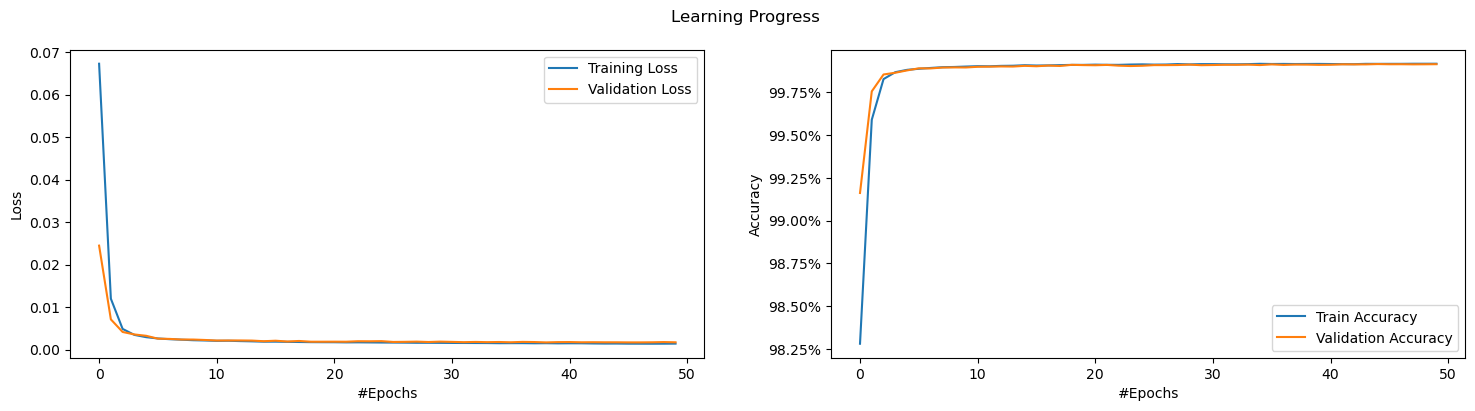

In [15]:
percentage_formatter = FuncFormatter(lambda y, _: '{:.2%}'.format(y))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

ax1.set(xlabel='#Epochs', ylabel='Loss')
fig.suptitle('Learning Progress')
ax1.plot(train_losses_fam, label="Training Loss")
ax1.plot(val_losses_fam, label="Validation Loss")
ax1.yaxis.set_major_formatter(percentage_formatter)
ax1.legend()

ax2.set(xlabel='#Epochs', ylabel='Accuracy')
ax2.plot(train_accuracies_fam, label="Train Accuracy")
ax2.plot(val_accuracies_fam, label="Validation Accuracy")
ax2.yaxis.set_major_formatter(percentage_formatter)
ax2.legend()

real_validation_errors = [1.0 - (train_accuracy + abs(val_accuracy - train_accuracy)) for train_accuracy, val_accuracy in zip(train_accuracies_fam,val_accuracies_fam)]
ax3.set(xlabel='#Epochs', ylabel='Real Val Error (e_train + |e_val - e_train|)')
ax3.plot(real_validation_errors)
ax3.yaxis.set_major_formatter(percentage_formatter)

Since the model's accuracy against the validation set is already higher than 99.9% and doesn't show signs of overfitting, we see little potential in optimizing it further and kept Karl relatively simple.

# Evaluation

In [16]:
# Some helper methods for prediction of graphs

def check_for_cycle(graph: Graph, source: Part, sink: Part):
    graph.add_undirected_edge(source, sink)
    return graph.is_cyclic()

def get_parts_with_fam_id(parts: List[Part], fam_id: int) -> List[Part]:
    return [part for part in parts if part.get_ofid() == fam_id]


def get_least_fam_id_neighbours_node(graph: Graph, nodes: List[Node], fam_id: int) -> Node:
    balance_counts = [0] * len(nodes)
    for i, node in enumerate(nodes):
        edges = graph.get_edges().get(node)
        if edges is not None:
            balance_counts[i] = \
                sum(1 if n.get_ofid() == fam_id else 0 for n in edges)

    balanced_node_idx: int = np.array(balance_counts).argmin()
    node = nodes[balanced_node_idx]
    return node

In [17]:
class GraphenGuruGuenterFamId(MyPredictionModel):

    def __init__(self, model, fam_mapping):
        self.model = model
        self.fam_mapping = fam_mapping

    def predict_graph(self, parts: Set[Part]) -> Graph:
        raw_predictions = []
        feature_tensors = create_features_family_id(parts, self.fam_mapping)
        for feature_tensor in feature_tensors:
            prediction = self.model(feature_tensor)
            raw_predictions.append(prediction)
        raw_predictions = torch.stack(raw_predictions)
        return self.build_predicted_graph(parts, raw_predictions)

    def build_predicted_graph(self, parts: Set[Part], pred_adj_matrix: Tensor) -> Graph:
        parts_list = sorted(list(parts))
        added_parts = set()
        node_count = len(parts_list)
        predicted_graph = Graph()
        parts_at_nodes = dict()
        for p in parts:
            parts_at_nodes[p] = []

        while predicted_graph.get_edge_count() // 2 < node_count - 1 and not torch.all(pred_adj_matrix < 1e-3):
            max_signal_idx = (pred_adj_matrix == torch.max(pred_adj_matrix)).nonzero()
            source_idx = max_signal_idx[0][0].item()
            sink_dense_fam_id = max_signal_idx[0][1].item()

            source_orig_fam_id = parts_list[source_idx].get_ofid()
            sink_orig_fam_id = self.fam_mapping.to_orig(sink_dense_fam_id)
            source = parts_list[source_idx]

            parts_with_sink_fam_id = get_parts_with_fam_id(parts_list, sink_orig_fam_id)
            parts_with_sink_fam_id = sorted(parts_with_sink_fam_id, key=lambda x: parts_at_nodes[x].count(source_orig_fam_id))

            for sink in parts_with_sink_fam_id:
                if (source != sink and not (source in added_parts and sink in added_parts)) or not predicted_graph.is_reachable(source, sink):
                    parts_at_nodes[source] += [sink_orig_fam_id]
                    parts_at_nodes[sink] += [source_orig_fam_id]
                    predicted_graph.add_undirected_edge(source, sink)
                    added_parts.add(source)
                    added_parts.add(sink)
                    break


            pred_adj_matrix[source_idx][sink_dense_fam_id] = 0.0
        return predicted_graph


predictor = GraphenGuruGuenterFamId(model_karl_fam_id.cpu(), fam_mapper)
with torch.no_grad():
    st = time.time()
    accuracy = evaluate_graphs(predictor, val_graphs)
    print(f"Mean edge accuracy: {accuracy}")
    et = time.time()
    print(f"Execution time: {(et - st):.2f}s")

100%|██████████| 1116/1116 [02:30<00:00,  7.43it/s]

Mean edge accuracy: 98.8855622089155
Execution time: 150.20s


# Training with part IDs

Here we perform training and evaluation of the model using only the part IDs. The model is structurally the same but has more parameters in order to handle the larger feature vectors.

In [19]:
if not model_part_exists:
    model_karl_part_id = Net(input_size=input_size_part, hidden_size=hidden_size_part, output_size=output_size_part).to(device)

    st = time.time()
    train_losses_part, val_losses_part, train_accuracies_part, val_accuracies_part = \
        train(model=model_karl_part_id, lr=learning_rate, epochs=20, train_loader=train_loader_part_id, val_loader=val_loader_part_id)

    et = time.time()
    print(f"Execution time: {(et - st):.2f} seconds")
    with open("data/karl_part.dat", mode="xb") as f:
        pickle.dump(model_karl_part_id, file=f)


else:
    with open("data/karl_part.dat", mode="rb") as f:
        model_karl_part_id = pickle.load(f)



100%|██████████| 20/20 [02:58<00:00,  8.90s/it]

Execution time: 178.04 seconds


Plot the resulting graphs for training with part IDs

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

ax1.set(xlabel='#Epochs', ylabel='Loss')
fig.suptitle('Learning Progress')
ax1.plot(train_losses_part, label="Training Loss")
ax1.plot(val_losses_part, label="Validation Loss")
ax1.legend()

ax2.set(xlabel='#Epochs', ylabel='Accuracy')
ax2.plot(train_accuracies_part, label="Train Accuracy")
ax2.plot(val_accuracies_part, label="Validation Accuracy")
ax2.legend()
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

real_validation_errors = [1.0 - (train_accuracy + abs(val_accuracy - train_accuracy)) for train_accuracy, val_accuracy in zip(train_accuracies_part,val_accuracies_part)]
ax3.set(xlabel='#Epochs', ylabel='Real Val Error (e_train + |e_val - e_train|)')
ax3.plot(real_validation_errors)
ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

In [ ]:
# Some helper methods for prediction of graphs with part IDs

def get_parts_with_part_id(parts: List[Part], part_id: int) -> List[Part]:
    return [part for part in parts if part.get_opid() == part_id]

In [ ]:
class GraphenGuruGuenterPartId(MyPredictionModel):

    def __init__(self, model, part_mapping):
        self.model = model
        self.part_mapping = part_mapping

    def predict_graph(self, parts: Set[Part]) -> Graph:
        raw_predictions = []
        feature_tensors = create_features_part_id(parts, self.part_mapping)
        for feature_tensor in feature_tensors:
            prediction = self.model(feature_tensor)
            raw_predictions.append(prediction)
        raw_predictions = torch.stack(raw_predictions)
        return self.build_predicted_graph(parts, raw_predictions)

    def build_predicted_graph(self, parts: Set[Part], pred_adj_matrix: Tensor) -> Graph:
        parts_list = sorted(list(parts))
        added_parts = set()
        node_count = len(parts_list)
        predicted_graph = Graph()
        parts_at_nodes = dict()
        for p in parts:
            parts_at_nodes[p] = []

        while predicted_graph.get_edge_count() // 2 < node_count - 1 and not torch.all(pred_adj_matrix == 0):

            max_signal_idx = (pred_adj_matrix == torch.max(pred_adj_matrix)).nonzero()
            source_idx = max_signal_idx[0][0].item()
            sink_dense_part_id = max_signal_idx[0][1].item()

            source_orig_part_id = parts_list[source_idx].get_opid()
            sink_orig_part_id = self.part_mapping.to_orig(sink_dense_part_id)
            source = parts_list[source_idx]

            parts_with_sink_part_id = get_parts_with_part_id(parts_list, sink_orig_part_id)
            parts_with_sink_part_id = sorted(parts_with_sink_part_id, key=lambda x: parts_at_nodes[x].count(source_orig_part_id))

            for sink in parts_with_sink_part_id:
                if source != sink and not (source in added_parts and sink in added_parts) or not predicted_graph.is_reachable(source,sink):
                    parts_at_nodes[source] += [sink_orig_part_id]
                    parts_at_nodes[sink] += [source_orig_part_id]
                    predicted_graph.add_undirected_edge(source, sink)
                    added_parts.add(source)
                    added_parts.add(sink)

            pred_adj_matrix[source_idx][sink_dense_part_id] = 0.0
        return predicted_graph


predictor = GraphenGuruGuenterPartId(model_karl_part_id.cpu(), part_mapper)

with torch.no_grad():
    st = time.time()
    accuracy = evaluate_graphs(predictor, val_graphs)
    print(f"Mean edge accuracy: {accuracy}")
    et = time.time()
    print(f"Execution time: {(et - st):.2f}s")

# Family IDs or part IDs?

As can be seen above, the model using only the part IDs has approximately the same performance as the model using only the family IDs. Because training and inference with the latter is much faster we stick to the approach with the family IDs from here on.

# Hyperparameter tuning

Because our model is very fast to train, we can try a lot of different hyperparameter settings. As described in the lecture we use a grid search approach here for finding the best hyperparameter setting. We will tune hidden layer size, learning rate, epochs. We intentionally skip the drawing of the loss and accuracy charts to no clutter the output due to the high number of combinations.

In [ ]:
import itertools
from prettytable import PrettyTable

num_ids = len(fam_mapper)
hidden_layer_sizes = [1 * num_ids, 2 * num_ids]
learning_rates = [0.001, 0.01]
epochs = [10, 20, 50]
permutations = list(itertools.product(hidden_layer_sizes, learning_rates, epochs))

results = []
best_predictor = None
best_accuracy = 0.
with tqdm(permutations) as permutation_progress:
    for layer_size, lr, epochs in permutation_progress:
        model_karl_fam_id = Net(input_size=input_size_fam, hidden_size=layer_size, output_size=output_size_fam).to(device)
        train(model=model_karl_fam_id, lr=lr, epochs=epochs, train_loader=train_loader_fam_id, val_loader=val_loader_fam_id, show_progress=False)

        predictor = GraphenGuruGuenterFamId(model_karl_fam_id.cpu(), fam_mapper)

        with torch.no_grad():
            accuracy = evaluate_graphs(predictor, val_graphs, show_progress=False)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_predictor = predictor
            results.append((layer_size, lr, epochs, accuracy))


results =  sorted(results, key=lambda x: x[3], reverse=True)
t = PrettyTable(['Hidden Layer Size', 'Learning Rate', 'Epochs', 'Accuracy'])
for row in results:
    t.add_row(row)

print(t)

Save prediction model

In [ ]:
try:
    with open('data/karl.dat', 'xb') as file:
        pickle.dump(predictor, file=file)
except FileExistsError:
    print("Accidental overwrite protection: File already exists")

In [ ]:
try:
    with open('data/karl.dat', 'rb') as file:
        test_predictor = pickle.load(file)
    with torch.no_grad():
        st = time.time()
        accuracy = evaluate_graphs(test_predictor, test_graphs)
        print(f"Mean edge accuracy: {accuracy}")
        et = time.time()
        print(f"Execution time: {(et - st):.2f}s")
except FileNotFoundError:
    print("Model file not found")